# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.9

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 200

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 50

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)


train.transforms = Compose(
      Compose(
        ToImage()
        ToDtype(scale=True)
  )
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 128
valid.transforms = (Compose(
      ToImage()
      ToDtype(scale=True)
),) 128
test.transforms = Compose(
      ToImage()
      ToDtype(scale=True)
) 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
# scheduler = ExponentialLR(optimizer, gamma=0.95)
# scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=10, factor=0.1, cooldown=40)
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.1

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])


for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/200] :


1 Train: 100%|███████| 352/352 [00:44<00:00,  7.94it/s]

Train Loss: 2.4392 | Train Acc: 10.14%


Valid Loss: 2.3026 | Valid Acc: 10.54%
Test  Loss: 2.2731 | Test Acc: 11.84%
updated best eval loss : 2.3025917768478394
--------------------------------------------------
[Epoch 2/200] :


2 Train: 100%|███████| 352/352 [00:40<00:00,  8.66it/s]


Train Loss: 2.2912 | Train Acc: 11.15%
Valid Loss: 2.2725 | Valid Acc: 11.64%
Test  Loss: 2.1843 | Test Acc: 19.26%
updated best eval loss : 2.272497606277466
--------------------------------------------------
[Epoch 3/200] :


3 Train: 100%|███████| 352/352 [00:42<00:00,  8.32it/s]


Train Loss: 2.2190 | Train Acc: 14.71%
Valid Loss: 2.3702 | Valid Acc: 18.46%
Test  Loss: 2.1347 | Test Acc: 24.03%
--------------------------------------------------
[Epoch 4/200] :


4 Train: 100%|███████| 352/352 [00:41<00:00,  8.45it/s]


Train Loss: 1.9474 | Train Acc: 27.01%
Valid Loss: 1.9247 | Valid Acc: 27.58%
Test  Loss: 1.9977 | Test Acc: 27.22%
updated best eval loss : 1.9246782451868056
--------------------------------------------------
[Epoch 5/200] :


5 Train: 100%|███████| 352/352 [00:41<00:00,  8.54it/s]


Train Loss: 1.7368 | Train Acc: 36.17%
Valid Loss: 1.6566 | Valid Acc: 40.32%
Test  Loss: 1.4237 | Test Acc: 47.44%
updated best eval loss : 1.6565641939640046
--------------------------------------------------
[Epoch 6/200] :


6 Train: 100%|███████| 352/352 [00:41<00:00,  8.48it/s]


Train Loss: 1.5184 | Train Acc: 45.20%
Valid Loss: 1.5270 | Valid Acc: 45.62%
Test  Loss: 1.4045 | Test Acc: 49.57%
updated best eval loss : 1.5269904375076293
--------------------------------------------------
[Epoch 7/200] :


7 Train: 100%|███████| 352/352 [00:40<00:00,  8.61it/s]


Train Loss: 1.3488 | Train Acc: 51.90%
Valid Loss: 1.3751 | Valid Acc: 51.36%
Test  Loss: 1.1819 | Test Acc: 57.27%
updated best eval loss : 1.375141218304634
--------------------------------------------------
[Epoch 8/200] :


8 Train: 100%|███████| 352/352 [00:41<00:00,  8.50it/s]


Train Loss: 1.2195 | Train Acc: 56.78%
Valid Loss: 1.2237 | Valid Acc: 57.26%
Test  Loss: 0.8895 | Test Acc: 68.65%
updated best eval loss : 1.2236791044473647
--------------------------------------------------
[Epoch 9/200] :


9 Train: 100%|███████| 352/352 [00:41<00:00,  8.55it/s]


Train Loss: 1.1444 | Train Acc: 59.60%
Valid Loss: 1.2172 | Valid Acc: 58.24%
Test  Loss: 1.0417 | Test Acc: 65.41%
updated best eval loss : 1.2172000795602798
--------------------------------------------------
[Epoch 10/200] :


10 Train: 100%|██████| 352/352 [00:40<00:00,  8.66it/s]


Train Loss: 1.0755 | Train Acc: 62.24%
Valid Loss: 1.1195 | Valid Acc: 61.42%
Test  Loss: 0.9304 | Test Acc: 68.96%
updated best eval loss : 1.1194667503237725
--------------------------------------------------
[Epoch 11/200] :


11 Train: 100%|██████| 352/352 [00:40<00:00,  8.64it/s]


Train Loss: 1.0236 | Train Acc: 64.02%
Valid Loss: 1.0181 | Valid Acc: 64.62%
Test  Loss: 0.7194 | Test Acc: 75.06%
updated best eval loss : 1.018099357187748
--------------------------------------------------
[Epoch 12/200] :


12 Train: 100%|██████| 352/352 [00:41<00:00,  8.51it/s]


Train Loss: 0.9816 | Train Acc: 65.86%
Valid Loss: 1.0392 | Valid Acc: 64.12%
Test  Loss: 0.7286 | Test Acc: 75.14%
--------------------------------------------------
[Epoch 13/200] :


13 Train: 100%|██████| 352/352 [00:41<00:00,  8.52it/s]


Train Loss: 0.9509 | Train Acc: 66.70%
Valid Loss: 1.0349 | Valid Acc: 63.80%
Test  Loss: 0.8745 | Test Acc: 70.66%
--------------------------------------------------
[Epoch 14/200] :


14 Train: 100%|██████| 352/352 [00:41<00:00,  8.45it/s]


Train Loss: 0.9254 | Train Acc: 67.58%
Valid Loss: 1.0161 | Valid Acc: 65.36%
Test  Loss: 0.7424 | Test Acc: 74.76%
updated best eval loss : 1.0160651221871375
--------------------------------------------------
[Epoch 15/200] :


15 Train: 100%|██████| 352/352 [00:40<00:00,  8.64it/s]


Train Loss: 0.8968 | Train Acc: 68.82%
Valid Loss: 0.9092 | Valid Acc: 67.26%
Test  Loss: 0.6188 | Test Acc: 78.43%
updated best eval loss : 0.9092063158750534
--------------------------------------------------
[Epoch 16/200] :


16 Train: 100%|██████| 352/352 [00:41<00:00,  8.49it/s]


Train Loss: 0.8716 | Train Acc: 69.52%
Valid Loss: 1.0925 | Valid Acc: 63.42%
Test  Loss: 0.8782 | Test Acc: 71.76%
--------------------------------------------------
[Epoch 17/200] :


17 Train: 100%|██████| 352/352 [00:41<00:00,  8.55it/s]


Train Loss: 0.8603 | Train Acc: 70.05%
Valid Loss: 0.9449 | Valid Acc: 68.14%
Test  Loss: 0.6510 | Test Acc: 77.88%
--------------------------------------------------
[Epoch 18/200] :


18 Train: 100%|██████| 352/352 [00:41<00:00,  8.54it/s]


Train Loss: 0.8484 | Train Acc: 70.10%
Valid Loss: 0.9021 | Valid Acc: 69.60%
Test  Loss: 0.7449 | Test Acc: 75.49%
updated best eval loss : 0.9020965561270714
--------------------------------------------------
[Epoch 19/200] :


19 Train: 100%|██████| 352/352 [00:41<00:00,  8.53it/s]


Train Loss: 0.8210 | Train Acc: 71.30%
Valid Loss: 0.8528 | Valid Acc: 70.48%
Test  Loss: 0.6166 | Test Acc: 79.00%
updated best eval loss : 0.8527558542788028
--------------------------------------------------
[Epoch 20/200] :


20 Train: 100%|██████| 352/352 [00:39<00:00,  8.82it/s]


Train Loss: 0.8106 | Train Acc: 71.52%
Valid Loss: 0.9944 | Valid Acc: 66.64%
Test  Loss: 0.6881 | Test Acc: 77.14%
--------------------------------------------------
[Epoch 21/200] :


21 Train: 100%|██████| 352/352 [00:41<00:00,  8.56it/s]


Train Loss: 0.7938 | Train Acc: 72.28%
Valid Loss: 1.1180 | Valid Acc: 61.78%
Test  Loss: 0.9239 | Test Acc: 69.48%
--------------------------------------------------
[Epoch 22/200] :


22 Train: 100%|██████| 352/352 [00:41<00:00,  8.47it/s]


Train Loss: 0.7926 | Train Acc: 72.15%
Valid Loss: 0.8468 | Valid Acc: 70.54%
Test  Loss: 0.6555 | Test Acc: 77.86%
updated best eval loss : 0.8468485221266746
--------------------------------------------------
[Epoch 23/200] :


23 Train: 100%|██████| 352/352 [00:41<00:00,  8.57it/s]


Train Loss: 0.7746 | Train Acc: 72.95%
Valid Loss: 0.8505 | Valid Acc: 70.52%
Test  Loss: 0.5976 | Test Acc: 79.29%
--------------------------------------------------
[Epoch 24/200] :


24 Train: 100%|██████| 352/352 [00:41<00:00,  8.55it/s]


Train Loss: 0.7606 | Train Acc: 73.24%
Valid Loss: 0.9155 | Valid Acc: 67.68%
Test  Loss: 0.6337 | Test Acc: 78.33%
--------------------------------------------------
[Epoch 25/200] :


25 Train: 100%|██████| 352/352 [00:41<00:00,  8.55it/s]


Train Loss: 0.7591 | Train Acc: 73.41%
Valid Loss: 0.8386 | Valid Acc: 71.12%
Test  Loss: 0.5356 | Test Acc: 81.50%
updated best eval loss : 0.8386398032307625
--------------------------------------------------
[Epoch 26/200] :


26 Train: 100%|██████| 352/352 [00:40<00:00,  8.63it/s]


Train Loss: 0.7488 | Train Acc: 73.96%
Valid Loss: 0.8631 | Valid Acc: 70.48%
Test  Loss: 0.6642 | Test Acc: 77.75%
--------------------------------------------------
[Epoch 27/200] :


27 Train: 100%|██████| 352/352 [00:40<00:00,  8.73it/s]


Train Loss: 0.7355 | Train Acc: 74.13%
Valid Loss: 0.8514 | Valid Acc: 70.68%
Test  Loss: 0.5791 | Test Acc: 80.31%
--------------------------------------------------
[Epoch 28/200] :


28 Train: 100%|██████| 352/352 [00:41<00:00,  8.55it/s]


Train Loss: 0.7265 | Train Acc: 74.50%
Valid Loss: 0.8290 | Valid Acc: 71.44%
Test  Loss: 0.6490 | Test Acc: 78.25%
updated best eval loss : 0.8290366843342781
--------------------------------------------------
[Epoch 29/200] :


29 Train: 100%|██████| 352/352 [00:40<00:00,  8.72it/s]


Train Loss: 0.7205 | Train Acc: 74.95%
Valid Loss: 0.9558 | Valid Acc: 67.70%
Test  Loss: 0.6666 | Test Acc: 78.71%
--------------------------------------------------
[Epoch 30/200] :


30 Train: 100%|██████| 352/352 [00:43<00:00,  8.18it/s]


Train Loss: 0.7098 | Train Acc: 75.12%
Valid Loss: 0.7607 | Valid Acc: 73.62%
Test  Loss: 0.5467 | Test Acc: 81.19%
updated best eval loss : 0.7607047021389007
--------------------------------------------------
[Epoch 31/200] :


31 Train: 100%|██████| 352/352 [00:41<00:00,  8.50it/s]


Train Loss: 0.7075 | Train Acc: 75.56%
Valid Loss: 0.8558 | Valid Acc: 71.62%
Test  Loss: 0.5807 | Test Acc: 81.27%
--------------------------------------------------
[Epoch 32/200] :


32 Train: 100%|██████| 352/352 [00:42<00:00,  8.37it/s]


Train Loss: 0.7019 | Train Acc: 75.41%
Valid Loss: 0.8381 | Valid Acc: 71.60%
Test  Loss: 0.5536 | Test Acc: 81.05%
--------------------------------------------------
[Epoch 33/200] :


33 Train: 100%|██████| 352/352 [00:41<00:00,  8.40it/s]


Train Loss: 0.6975 | Train Acc: 75.73%
Valid Loss: 0.8507 | Valid Acc: 71.02%
Test  Loss: 0.5891 | Test Acc: 80.24%
--------------------------------------------------
[Epoch 34/200] :


34 Train: 100%|██████| 352/352 [00:45<00:00,  7.78it/s]


Train Loss: 0.6927 | Train Acc: 75.90%
Valid Loss: 0.7709 | Valid Acc: 73.46%
Test  Loss: 0.4974 | Test Acc: 82.87%
--------------------------------------------------
[Epoch 35/200] :


35 Train: 100%|██████| 352/352 [00:44<00:00,  8.00it/s]


Train Loss: 0.6866 | Train Acc: 76.02%
Valid Loss: 0.7583 | Valid Acc: 74.00%
Test  Loss: 0.5098 | Test Acc: 82.24%
updated best eval loss : 0.7583154425024986
--------------------------------------------------
[Epoch 36/200] :


36 Train: 100%|██████| 352/352 [00:43<00:00,  8.17it/s]


Train Loss: 0.6780 | Train Acc: 76.29%
Valid Loss: 0.8952 | Valid Acc: 69.20%
Test  Loss: 0.5645 | Test Acc: 80.98%
--------------------------------------------------
[Epoch 37/200] :


37 Train: 100%|██████| 352/352 [00:42<00:00,  8.21it/s]


Train Loss: 0.6719 | Train Acc: 76.67%
Valid Loss: 0.7696 | Valid Acc: 72.44%
Test  Loss: 0.5177 | Test Acc: 82.18%
--------------------------------------------------
[Epoch 38/200] :


38 Train: 100%|██████| 352/352 [00:41<00:00,  8.47it/s]


Train Loss: 0.6779 | Train Acc: 76.29%
Valid Loss: 0.9548 | Valid Acc: 68.24%
Test  Loss: 0.7227 | Test Acc: 77.41%
--------------------------------------------------
[Epoch 39/200] :


39 Train: 100%|██████| 352/352 [00:43<00:00,  8.19it/s]


Train Loss: 0.6676 | Train Acc: 76.67%
Valid Loss: 0.7236 | Valid Acc: 74.76%
Test  Loss: 0.4784 | Test Acc: 83.82%
updated best eval loss : 0.723596316576004
--------------------------------------------------
[Epoch 40/200] :


40 Train: 100%|██████| 352/352 [00:41<00:00,  8.52it/s]


Train Loss: 0.6549 | Train Acc: 77.00%
Valid Loss: 0.8304 | Valid Acc: 71.76%
Test  Loss: 0.5745 | Test Acc: 81.58%
--------------------------------------------------
[Epoch 41/200] :


41 Train: 100%|██████| 352/352 [00:40<00:00,  8.69it/s]


Train Loss: 0.6580 | Train Acc: 77.07%
Valid Loss: 0.9572 | Valid Acc: 68.20%
Test  Loss: 0.6787 | Test Acc: 78.21%
--------------------------------------------------
[Epoch 42/200] :


42 Train: 100%|██████| 352/352 [00:40<00:00,  8.66it/s]


Train Loss: 0.6600 | Train Acc: 76.92%
Valid Loss: 0.8250 | Valid Acc: 72.02%
Test  Loss: 0.5483 | Test Acc: 81.57%
--------------------------------------------------
[Epoch 43/200] :


43 Train: 100%|██████| 352/352 [00:40<00:00,  8.79it/s]


Train Loss: 0.6481 | Train Acc: 77.30%
Valid Loss: 0.7823 | Valid Acc: 73.44%
Test  Loss: 0.5601 | Test Acc: 81.39%
--------------------------------------------------
[Epoch 44/200] :


44 Train: 100%|██████| 352/352 [00:40<00:00,  8.67it/s]


Train Loss: 0.6462 | Train Acc: 77.39%
Valid Loss: 0.8106 | Valid Acc: 73.30%
Test  Loss: 0.4567 | Test Acc: 84.19%
--------------------------------------------------
[Epoch 45/200] :


45 Train: 100%|██████| 352/352 [00:32<00:00, 10.78it/s]


Train Loss: 0.6469 | Train Acc: 77.44%
Valid Loss: 0.7808 | Valid Acc: 73.94%
Test  Loss: 0.5173 | Test Acc: 82.85%
--------------------------------------------------
[Epoch 46/200] :


46 Train: 100%|██████| 352/352 [00:31<00:00, 11.16it/s]


Train Loss: 0.6402 | Train Acc: 77.84%
Valid Loss: 0.7767 | Valid Acc: 73.58%
Test  Loss: 0.5185 | Test Acc: 83.21%
--------------------------------------------------
[Epoch 47/200] :


47 Train: 100%|██████| 352/352 [00:31<00:00, 11.31it/s]


Train Loss: 0.6402 | Train Acc: 77.47%
Valid Loss: 0.8930 | Valid Acc: 70.52%
Test  Loss: 0.6890 | Test Acc: 77.84%
--------------------------------------------------
[Epoch 48/200] :


48 Train: 100%|██████| 352/352 [00:31<00:00, 11.08it/s]


Train Loss: 0.6291 | Train Acc: 77.90%
Valid Loss: 0.8736 | Valid Acc: 70.92%
Test  Loss: 0.6621 | Test Acc: 79.23%
--------------------------------------------------
[Epoch 49/200] :


49 Train: 100%|██████| 352/352 [00:30<00:00, 11.49it/s]


Train Loss: 0.6264 | Train Acc: 78.20%
Valid Loss: 0.7118 | Valid Acc: 76.02%
Test  Loss: 0.4965 | Test Acc: 83.45%
updated best eval loss : 0.7117872603237629
--------------------------------------------------
[Epoch 50/200] :


50 Train: 100%|██████| 352/352 [00:31<00:00, 11.21it/s]


Train Loss: 0.6297 | Train Acc: 78.11%
Valid Loss: 0.7691 | Valid Acc: 74.00%
Test  Loss: 0.4615 | Test Acc: 84.39%
--------------------------------------------------
[Epoch 51/200] :


51 Train: 100%|██████| 352/352 [00:31<00:00, 11.18it/s]


Train Loss: 0.6237 | Train Acc: 78.39%
Valid Loss: 0.7282 | Valid Acc: 74.22%
Test  Loss: 0.4390 | Test Acc: 84.73%
--------------------------------------------------
[Epoch 52/200] :


52 Train: 100%|██████| 352/352 [00:31<00:00, 11.26it/s]


Train Loss: 0.6244 | Train Acc: 78.23%
Valid Loss: 0.7366 | Valid Acc: 76.38%
Test  Loss: 0.4573 | Test Acc: 84.58%
--------------------------------------------------
[Epoch 53/200] :


53 Train: 100%|██████| 352/352 [00:31<00:00, 11.24it/s]


Train Loss: 0.6308 | Train Acc: 78.08%
Valid Loss: 0.7446 | Valid Acc: 74.62%
Test  Loss: 0.4697 | Test Acc: 84.26%
--------------------------------------------------
[Epoch 54/200] :


54 Train: 100%|██████| 352/352 [00:31<00:00, 11.26it/s]


Train Loss: 0.6159 | Train Acc: 78.50%
Valid Loss: 0.6911 | Valid Acc: 75.48%
Test  Loss: 0.4220 | Test Acc: 85.34%
updated best eval loss : 0.6910889349877835
--------------------------------------------------
[Epoch 55/200] :


55 Train: 100%|██████| 352/352 [00:31<00:00, 11.21it/s]


Train Loss: 0.6064 | Train Acc: 78.83%
Valid Loss: 0.6952 | Valid Acc: 76.16%
Test  Loss: 0.4602 | Test Acc: 84.26%
--------------------------------------------------
[Epoch 56/200] :


56 Train: 100%|██████| 352/352 [00:31<00:00, 11.16it/s]


Train Loss: 0.6105 | Train Acc: 78.50%
Valid Loss: 0.6940 | Valid Acc: 75.68%
Test  Loss: 0.4276 | Test Acc: 85.79%
--------------------------------------------------
[Epoch 57/200] :


57 Train: 100%|██████| 352/352 [00:31<00:00, 11.17it/s]


Train Loss: 0.6131 | Train Acc: 78.34%
Valid Loss: 0.6913 | Valid Acc: 76.34%
Test  Loss: 0.4591 | Test Acc: 84.01%
--------------------------------------------------
[Epoch 58/200] :


58 Train: 100%|██████| 352/352 [00:31<00:00, 11.31it/s]


Train Loss: 0.6085 | Train Acc: 78.51%
Valid Loss: 0.7047 | Valid Acc: 76.48%
Test  Loss: 0.4205 | Test Acc: 85.65%
--------------------------------------------------
[Epoch 59/200] :


59 Train: 100%|██████| 352/352 [00:31<00:00, 11.13it/s]


Train Loss: 0.6074 | Train Acc: 78.74%
Valid Loss: 0.7660 | Valid Acc: 74.18%
Test  Loss: 0.4858 | Test Acc: 83.72%
--------------------------------------------------
[Epoch 60/200] :


60 Train: 100%|██████| 352/352 [00:30<00:00, 11.38it/s]


Train Loss: 0.6002 | Train Acc: 79.12%
Valid Loss: 0.6528 | Valid Acc: 77.06%
Test  Loss: 0.4101 | Test Acc: 86.41%
updated best eval loss : 0.6528087921440602
--------------------------------------------------
[Epoch 61/200] :


61 Train: 100%|██████| 352/352 [00:31<00:00, 11.27it/s]


Train Loss: 0.5999 | Train Acc: 79.18%
Valid Loss: 0.7485 | Valid Acc: 75.72%
Test  Loss: 0.4684 | Test Acc: 84.82%
--------------------------------------------------
[Epoch 62/200] :


62 Train: 100%|██████| 352/352 [00:31<00:00, 11.34it/s]


Train Loss: 0.5945 | Train Acc: 79.36%
Valid Loss: 0.7512 | Valid Acc: 75.14%
Test  Loss: 0.5038 | Test Acc: 83.43%
--------------------------------------------------
[Epoch 63/200] :


63 Train: 100%|██████| 352/352 [00:31<00:00, 11.21it/s]


Train Loss: 0.6033 | Train Acc: 78.93%
Valid Loss: 0.7162 | Valid Acc: 75.54%
Test  Loss: 0.5052 | Test Acc: 83.14%
--------------------------------------------------
[Epoch 64/200] :


64 Train: 100%|██████| 352/352 [00:31<00:00, 11.31it/s]


Train Loss: 0.5945 | Train Acc: 79.38%
Valid Loss: 0.7696 | Valid Acc: 73.40%
Test  Loss: 0.5757 | Test Acc: 80.55%
--------------------------------------------------
[Epoch 65/200] :


65 Train: 100%|██████| 352/352 [00:30<00:00, 11.38it/s]


Train Loss: 0.5894 | Train Acc: 79.41%
Valid Loss: 0.8657 | Valid Acc: 71.50%
Test  Loss: 0.4909 | Test Acc: 83.49%
--------------------------------------------------
[Epoch 66/200] :


66 Train: 100%|██████| 352/352 [00:31<00:00, 11.30it/s]


Train Loss: 0.5905 | Train Acc: 79.55%
Valid Loss: 0.7322 | Valid Acc: 75.00%
Test  Loss: 0.5109 | Test Acc: 83.70%
--------------------------------------------------
[Epoch 67/200] :


67 Train: 100%|██████| 352/352 [00:31<00:00, 11.27it/s]


Train Loss: 0.6005 | Train Acc: 79.08%
Valid Loss: 0.6665 | Valid Acc: 77.44%
Test  Loss: 0.4312 | Test Acc: 85.14%
--------------------------------------------------
[Epoch 68/200] :


68 Train: 100%|██████| 352/352 [00:31<00:00, 11.18it/s]


Train Loss: 0.5798 | Train Acc: 79.80%
Valid Loss: 0.6519 | Valid Acc: 77.28%
Test  Loss: 0.3894 | Test Acc: 86.92%
updated best eval loss : 0.6518682762980461
--------------------------------------------------
[Epoch 69/200] :


69 Train: 100%|██████| 352/352 [00:31<00:00, 11.20it/s]


Train Loss: 0.6008 | Train Acc: 78.91%
Valid Loss: 0.6617 | Valid Acc: 77.88%
Test  Loss: 0.3853 | Test Acc: 86.69%
--------------------------------------------------
[Epoch 70/200] :


70 Train: 100%|██████| 352/352 [00:31<00:00, 11.02it/s]


Train Loss: 0.5920 | Train Acc: 79.17%
Valid Loss: 0.7274 | Valid Acc: 75.00%
Test  Loss: 0.3999 | Test Acc: 86.35%
--------------------------------------------------
[Epoch 71/200] :


71 Train: 100%|██████| 352/352 [00:31<00:00, 11.26it/s]


Train Loss: 0.5800 | Train Acc: 79.72%
Valid Loss: 0.6975 | Valid Acc: 76.28%
Test  Loss: 0.4471 | Test Acc: 85.65%
--------------------------------------------------
[Epoch 72/200] :


72 Train: 100%|██████| 352/352 [00:31<00:00, 11.28it/s]


Train Loss: 0.5805 | Train Acc: 79.72%
Valid Loss: 0.7095 | Valid Acc: 76.14%
Test  Loss: 0.4268 | Test Acc: 85.45%
--------------------------------------------------
[Epoch 73/200] :


73 Train: 100%|██████| 352/352 [00:31<00:00, 11.32it/s]


Train Loss: 0.5779 | Train Acc: 79.88%
Valid Loss: 0.6564 | Valid Acc: 78.28%
Test  Loss: 0.3970 | Test Acc: 86.98%
--------------------------------------------------
[Epoch 74/200] :


74 Train: 100%|██████| 352/352 [00:31<00:00, 11.13it/s]


Train Loss: 0.5774 | Train Acc: 79.94%
Valid Loss: 0.7155 | Valid Acc: 75.46%
Test  Loss: 0.4483 | Test Acc: 84.98%
--------------------------------------------------
[Epoch 75/200] :


75 Train: 100%|██████| 352/352 [00:30<00:00, 11.47it/s]


Train Loss: 0.5814 | Train Acc: 79.63%
Valid Loss: 0.6955 | Valid Acc: 75.94%
Test  Loss: 0.4485 | Test Acc: 84.87%
--------------------------------------------------
[Epoch 76/200] :


76 Train: 100%|██████| 352/352 [00:30<00:00, 11.38it/s]


Train Loss: 0.5788 | Train Acc: 79.80%
Valid Loss: 0.6590 | Valid Acc: 76.68%
Test  Loss: 0.4323 | Test Acc: 85.14%
--------------------------------------------------
[Epoch 77/200] :


77 Train: 100%|██████| 352/352 [00:31<00:00, 11.27it/s]


Train Loss: 0.5719 | Train Acc: 80.04%
Valid Loss: 0.6971 | Valid Acc: 76.38%
Test  Loss: 0.3953 | Test Acc: 86.89%
--------------------------------------------------
[Epoch 78/200] :


78 Train: 100%|██████| 352/352 [00:31<00:00, 11.20it/s]


Train Loss: 0.5777 | Train Acc: 79.94%
Valid Loss: 0.7227 | Valid Acc: 75.40%
Test  Loss: 0.4729 | Test Acc: 84.19%
--------------------------------------------------
[Epoch 79/200] :


79 Train: 100%|██████| 352/352 [00:31<00:00, 11.19it/s]


Train Loss: 0.5786 | Train Acc: 79.79%
Valid Loss: 0.6339 | Valid Acc: 78.40%
Test  Loss: 0.4009 | Test Acc: 86.42%
updated best eval loss : 0.6338638365268707
--------------------------------------------------
[Epoch 80/200] :


80 Train: 100%|██████| 352/352 [00:31<00:00, 11.34it/s]


Train Loss: 0.5647 | Train Acc: 80.16%
Valid Loss: 0.7141 | Valid Acc: 75.66%
Test  Loss: 0.4548 | Test Acc: 84.83%
--------------------------------------------------
[Epoch 81/200] :


81 Train: 100%|██████| 352/352 [00:31<00:00, 11.11it/s]


Train Loss: 0.5666 | Train Acc: 80.12%
Valid Loss: 0.8252 | Valid Acc: 73.04%
Test  Loss: 0.5432 | Test Acc: 82.91%
--------------------------------------------------
[Epoch 82/200] :


82 Train: 100%|██████| 352/352 [00:30<00:00, 11.41it/s]


Train Loss: 0.5624 | Train Acc: 80.32%
Valid Loss: 0.8212 | Valid Acc: 73.26%
Test  Loss: 0.6332 | Test Acc: 80.08%
--------------------------------------------------
[Epoch 83/200] :


83 Train: 100%|██████| 352/352 [00:31<00:00, 11.21it/s]


Train Loss: 0.5697 | Train Acc: 80.20%
Valid Loss: 0.7290 | Valid Acc: 76.30%
Test  Loss: 0.4891 | Test Acc: 84.74%
--------------------------------------------------
[Epoch 84/200] :


84 Train: 100%|██████| 352/352 [00:31<00:00, 11.23it/s]


Train Loss: 0.5701 | Train Acc: 80.05%
Valid Loss: 0.7018 | Valid Acc: 75.22%
Test  Loss: 0.4428 | Test Acc: 84.63%
--------------------------------------------------
[Epoch 85/200] :


85 Train: 100%|██████| 352/352 [00:30<00:00, 11.38it/s]


Train Loss: 0.5638 | Train Acc: 80.27%
Valid Loss: 0.6843 | Valid Acc: 76.96%
Test  Loss: 0.4562 | Test Acc: 84.49%
--------------------------------------------------
[Epoch 86/200] :


86 Train: 100%|██████| 352/352 [00:30<00:00, 11.44it/s]


Train Loss: 0.5661 | Train Acc: 80.26%
Valid Loss: 0.6595 | Valid Acc: 77.02%
Test  Loss: 0.3850 | Test Acc: 87.12%
--------------------------------------------------
[Epoch 87/200] :


87 Train: 100%|██████| 352/352 [00:31<00:00, 11.26it/s]


Train Loss: 0.5621 | Train Acc: 80.21%
Valid Loss: 0.7203 | Valid Acc: 75.68%
Test  Loss: 0.4633 | Test Acc: 85.07%
--------------------------------------------------
[Epoch 88/200] :


88 Train: 100%|██████| 352/352 [00:30<00:00, 11.45it/s]


Train Loss: 0.5634 | Train Acc: 80.46%
Valid Loss: 0.6370 | Valid Acc: 78.34%
Test  Loss: 0.3799 | Test Acc: 87.08%
--------------------------------------------------
[Epoch 89/200] :


89 Train: 100%|██████| 352/352 [00:31<00:00, 11.15it/s]


Train Loss: 0.5704 | Train Acc: 80.07%
Valid Loss: 0.6398 | Valid Acc: 77.88%
Test  Loss: 0.4027 | Test Acc: 86.33%
--------------------------------------------------
[Epoch 90/200] :


90 Train: 100%|██████| 352/352 [00:31<00:00, 11.31it/s]


Train Loss: 0.5610 | Train Acc: 80.25%
Valid Loss: 0.6795 | Valid Acc: 77.48%
Test  Loss: 0.3918 | Test Acc: 86.55%
--------------------------------------------------
[Epoch 91/200] :


91 Train: 100%|██████| 352/352 [00:31<00:00, 11.29it/s]


Train Loss: 0.4668 | Train Acc: 83.57%
Valid Loss: 0.5226 | Valid Acc: 82.30%
Test  Loss: 0.2911 | Test Acc: 90.07%
updated best eval loss : 0.5225748918950558
--------------------------------------------------
[Epoch 92/200] :


92 Train: 100%|██████| 352/352 [00:31<00:00, 11.24it/s]


Train Loss: 0.4307 | Train Acc: 85.00%
Valid Loss: 0.4914 | Valid Acc: 83.28%
Test  Loss: 0.2729 | Test Acc: 90.67%
updated best eval loss : 0.49140421152114866
--------------------------------------------------
[Epoch 93/200] :


93 Train: 100%|██████| 352/352 [00:31<00:00, 11.04it/s]


Train Loss: 0.4140 | Train Acc: 85.57%
Valid Loss: 0.4782 | Valid Acc: 83.54%
Test  Loss: 0.2689 | Test Acc: 90.84%
updated best eval loss : 0.4782248631119728
--------------------------------------------------
[Epoch 94/200] :


94 Train: 100%|██████| 352/352 [00:32<00:00, 10.94it/s]


Train Loss: 0.4063 | Train Acc: 85.84%
Valid Loss: 0.4901 | Valid Acc: 82.84%
Test  Loss: 0.2652 | Test Acc: 91.08%
--------------------------------------------------
[Epoch 95/200] :


95 Train: 100%|██████| 352/352 [00:31<00:00, 11.15it/s]


Train Loss: 0.3968 | Train Acc: 86.06%
Valid Loss: 0.4848 | Valid Acc: 82.82%
Test  Loss: 0.2741 | Test Acc: 90.92%
--------------------------------------------------
[Epoch 96/200] :


96 Train: 100%|██████| 352/352 [00:31<00:00, 11.11it/s]


Train Loss: 0.3902 | Train Acc: 86.26%
Valid Loss: 0.4846 | Valid Acc: 83.12%
Test  Loss: 0.2633 | Test Acc: 91.18%
--------------------------------------------------
[Epoch 97/200] :


97 Train: 100%|██████| 352/352 [00:32<00:00, 10.68it/s]


Train Loss: 0.3848 | Train Acc: 86.54%
Valid Loss: 0.4764 | Valid Acc: 83.60%
Test  Loss: 0.2629 | Test Acc: 91.09%
updated best eval loss : 0.4763590842485428
--------------------------------------------------
[Epoch 98/200] :


98 Train: 100%|██████| 352/352 [00:31<00:00, 11.22it/s]


Train Loss: 0.3825 | Train Acc: 86.57%
Valid Loss: 0.4661 | Valid Acc: 83.70%
Test  Loss: 0.2569 | Test Acc: 91.32%
updated best eval loss : 0.46611050963401796
--------------------------------------------------
[Epoch 99/200] :


99 Train: 100%|██████| 352/352 [00:31<00:00, 11.29it/s]


Train Loss: 0.3792 | Train Acc: 86.84%
Valid Loss: 0.4812 | Valid Acc: 83.98%
Test  Loss: 0.2547 | Test Acc: 91.45%
--------------------------------------------------
[Epoch 100/200] :


100 Train: 100%|█████| 352/352 [00:31<00:00, 11.10it/s]


Train Loss: 0.3837 | Train Acc: 86.58%
Valid Loss: 0.4987 | Valid Acc: 83.52%
Test  Loss: 0.2644 | Test Acc: 91.12%
--------------------------------------------------
[Epoch 101/200] :


101 Train: 100%|█████| 352/352 [00:31<00:00, 11.30it/s]


Train Loss: 0.3789 | Train Acc: 86.65%
Valid Loss: 0.4802 | Valid Acc: 83.62%
Test  Loss: 0.2539 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 102/200] :


102 Train: 100%|█████| 352/352 [00:31<00:00, 11.19it/s]


Train Loss: 0.3713 | Train Acc: 87.09%
Valid Loss: 0.4769 | Valid Acc: 83.74%
Test  Loss: 0.2581 | Test Acc: 91.59%
--------------------------------------------------
[Epoch 103/200] :


103 Train: 100%|█████| 352/352 [00:32<00:00, 10.96it/s]


Train Loss: 0.3735 | Train Acc: 86.92%
Valid Loss: 0.4741 | Valid Acc: 83.24%
Test  Loss: 0.2577 | Test Acc: 91.47%
--------------------------------------------------
[Epoch 104/200] :


104 Train: 100%|█████| 352/352 [00:31<00:00, 11.09it/s]


Train Loss: 0.3686 | Train Acc: 87.03%
Valid Loss: 0.4569 | Valid Acc: 84.70%
Test  Loss: 0.2546 | Test Acc: 91.49%
updated best eval loss : 0.4569371145218611
--------------------------------------------------
[Epoch 105/200] :


105 Train: 100%|█████| 352/352 [00:30<00:00, 11.38it/s]


Train Loss: 0.3676 | Train Acc: 87.28%
Valid Loss: 0.4629 | Valid Acc: 84.56%
Test  Loss: 0.2514 | Test Acc: 91.45%
--------------------------------------------------
[Epoch 106/200] :


106 Train: 100%|█████| 352/352 [00:31<00:00, 11.28it/s]


Train Loss: 0.3635 | Train Acc: 87.36%
Valid Loss: 0.4774 | Valid Acc: 83.62%
Test  Loss: 0.2637 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 107/200] :


107 Train: 100%|█████| 352/352 [00:31<00:00, 11.09it/s]


Train Loss: 0.3542 | Train Acc: 87.52%
Valid Loss: 0.4722 | Valid Acc: 84.10%
Test  Loss: 0.2496 | Test Acc: 91.63%
--------------------------------------------------
[Epoch 108/200] :


108 Train: 100%|█████| 352/352 [00:31<00:00, 11.31it/s]


Train Loss: 0.3685 | Train Acc: 86.99%
Valid Loss: 0.4886 | Valid Acc: 83.82%
Test  Loss: 0.2678 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 109/200] :


109 Train: 100%|█████| 352/352 [00:31<00:00, 11.07it/s]


Train Loss: 0.3598 | Train Acc: 87.39%
Valid Loss: 0.4710 | Valid Acc: 84.62%
Test  Loss: 0.2503 | Test Acc: 91.60%
--------------------------------------------------
[Epoch 110/200] :


110 Train: 100%|█████| 352/352 [00:31<00:00, 11.13it/s]


Train Loss: 0.3584 | Train Acc: 87.40%
Valid Loss: 0.4848 | Valid Acc: 83.46%
Test  Loss: 0.2466 | Test Acc: 91.77%
--------------------------------------------------
[Epoch 111/200] :


111 Train: 100%|█████| 352/352 [00:31<00:00, 11.17it/s]


Train Loss: 0.3533 | Train Acc: 87.60%
Valid Loss: 0.4547 | Valid Acc: 84.58%
Test  Loss: 0.2509 | Test Acc: 91.44%
updated best eval loss : 0.45470561534166337
--------------------------------------------------
[Epoch 112/200] :


112 Train: 100%|█████| 352/352 [00:31<00:00, 11.26it/s]


Train Loss: 0.3529 | Train Acc: 87.62%
Valid Loss: 0.4971 | Valid Acc: 83.88%
Test  Loss: 0.2524 | Test Acc: 91.55%
--------------------------------------------------
[Epoch 113/200] :


113 Train: 100%|█████| 352/352 [00:31<00:00, 11.27it/s]


Train Loss: 0.3528 | Train Acc: 87.71%
Valid Loss: 0.4630 | Valid Acc: 84.20%
Test  Loss: 0.2539 | Test Acc: 91.46%
--------------------------------------------------
[Epoch 114/200] :


114 Train: 100%|█████| 352/352 [00:31<00:00, 11.19it/s]


Train Loss: 0.3460 | Train Acc: 87.84%
Valid Loss: 0.4616 | Valid Acc: 84.50%
Test  Loss: 0.2556 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 115/200] :


115 Train: 100%|█████| 352/352 [00:31<00:00, 11.24it/s]


Train Loss: 0.3522 | Train Acc: 87.53%
Valid Loss: 0.4687 | Valid Acc: 83.84%
Test  Loss: 0.2548 | Test Acc: 91.49%
--------------------------------------------------
[Epoch 116/200] :


116 Train: 100%|█████| 352/352 [00:31<00:00, 11.12it/s]


Train Loss: 0.3484 | Train Acc: 87.78%
Valid Loss: 0.4735 | Valid Acc: 84.24%
Test  Loss: 0.2517 | Test Acc: 91.64%
--------------------------------------------------
[Epoch 117/200] :


117 Train: 100%|█████| 352/352 [00:31<00:00, 11.30it/s]


Train Loss: 0.3448 | Train Acc: 87.88%
Valid Loss: 0.4885 | Valid Acc: 83.58%
Test  Loss: 0.2595 | Test Acc: 91.42%
--------------------------------------------------
[Epoch 118/200] :


118 Train: 100%|█████| 352/352 [00:31<00:00, 11.24it/s]


Train Loss: 0.3441 | Train Acc: 87.97%
Valid Loss: 0.4770 | Valid Acc: 83.52%
Test  Loss: 0.2533 | Test Acc: 91.75%
--------------------------------------------------
[Epoch 119/200] :


119 Train: 100%|█████| 352/352 [00:31<00:00, 11.22it/s]


Train Loss: 0.3462 | Train Acc: 87.83%
Valid Loss: 0.4688 | Valid Acc: 84.04%
Test  Loss: 0.2536 | Test Acc: 91.73%
--------------------------------------------------
[Epoch 120/200] :


120 Train: 100%|█████| 352/352 [00:32<00:00, 10.73it/s]


Train Loss: 0.3460 | Train Acc: 87.90%
Valid Loss: 0.4591 | Valid Acc: 84.44%
Test  Loss: 0.2486 | Test Acc: 91.76%
--------------------------------------------------
[Epoch 121/200] :


121 Train: 100%|█████| 352/352 [00:31<00:00, 11.18it/s]


Train Loss: 0.3377 | Train Acc: 88.07%
Valid Loss: 0.4664 | Valid Acc: 84.30%
Test  Loss: 0.2536 | Test Acc: 91.42%
--------------------------------------------------
[Epoch 122/200] :


122 Train: 100%|█████| 352/352 [00:31<00:00, 11.14it/s]


Train Loss: 0.3358 | Train Acc: 88.31%
Valid Loss: 0.4713 | Valid Acc: 83.84%
Test  Loss: 0.2544 | Test Acc: 91.65%
--------------------------------------------------
[Epoch 123/200] :


123 Train: 100%|█████| 352/352 [00:31<00:00, 11.08it/s]


Train Loss: 0.3344 | Train Acc: 88.22%
Valid Loss: 0.4668 | Valid Acc: 84.40%
Test  Loss: 0.2469 | Test Acc: 91.95%
--------------------------------------------------
[Epoch 124/200] :


124 Train: 100%|█████| 352/352 [00:31<00:00, 11.05it/s]


Train Loss: 0.3354 | Train Acc: 88.20%
Valid Loss: 0.4561 | Valid Acc: 84.54%
Test  Loss: 0.2447 | Test Acc: 91.96%
--------------------------------------------------
[Epoch 125/200] :


125 Train: 100%|█████| 352/352 [00:31<00:00, 11.05it/s]


Train Loss: 0.3325 | Train Acc: 88.26%
Valid Loss: 0.4537 | Valid Acc: 84.52%
Test  Loss: 0.2530 | Test Acc: 91.61%
updated best eval loss : 0.4536991432309151
--------------------------------------------------
[Epoch 126/200] :


126 Train:  95%|████▋| 334/352 [00:30<00:01, 11.02it/s]

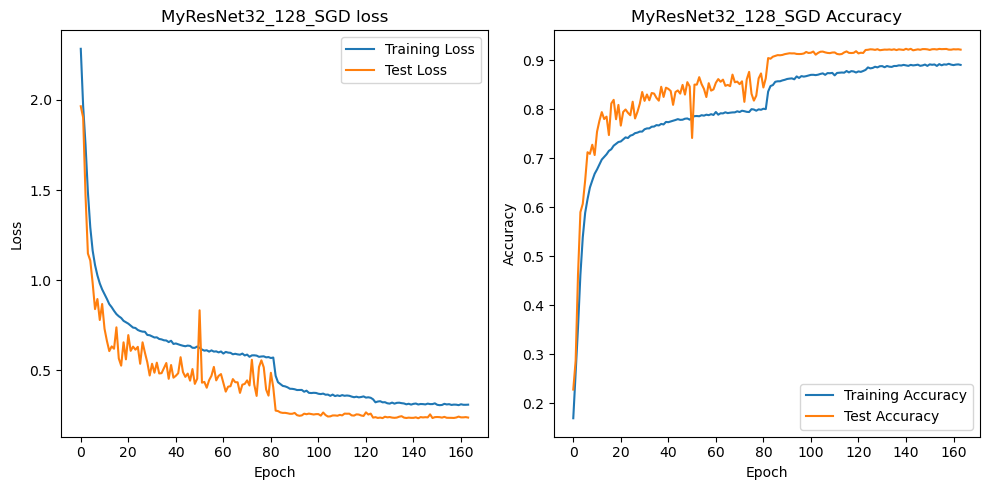

In [ ]:
view = LogViewer(logs)
view.draw(title=file_name, save=True)

In [ ]:
view.print_all()

1 epoch: train_loss=2.2826, train_acc=0.1693, test_loss=1.9642, test_acc=0.2279, lr=0.1000
2 epoch: train_loss=1.9653, train_acc=0.2625, test_loss=1.9019, test_acc=0.2867, lr=0.1000
3 epoch: train_loss=1.7514, train_acc=0.3551, test_loss=1.4698, test_acc=0.4636, lr=0.1000
4 epoch: train_loss=1.4882, train_acc=0.4621, test_loss=1.1483, test_acc=0.5901, lr=0.1000
5 epoch: train_loss=1.2936, train_acc=0.5389, test_loss=1.1093, test_acc=0.6072, lr=0.1000
6 epoch: train_loss=1.1643, train_acc=0.5887, test_loss=0.9847, test_acc=0.6548, lr=0.1000
7 epoch: train_loss=1.0845, train_acc=0.6166, test_loss=0.8402, test_acc=0.7125, lr=0.1000
8 epoch: train_loss=1.0271, train_acc=0.6404, test_loss=0.8961, test_acc=0.7092, lr=0.1000
9 epoch: train_loss=0.9825, train_acc=0.6548, test_loss=0.7799, test_acc=0.7278, lr=0.1000
10 epoch: train_loss=0.9492, train_acc=0.6685, test_loss=0.8685, test_acc=0.7068, lr=0.1000
11 epoch: train_loss=0.9233, train_acc=0.6773, test_loss=0.7309, test_acc=0.7545, lr=0.10